In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
import random

import scipy.stats as stats

In [149]:
plt.style.use('ggplot')

In [150]:
df = pd.read_csv('../data/kandidater_data.csv').dropna()

TREATMENT = 'IsFemale'
OUTCOME = [str(i) for i in range(1, 31)]

# gender dummy question
df[TREATMENT] = df["Gender"].map(lambda x: True if x == "F" else False)
df['26'] = df["Gender"].map(lambda x: -2 if x == "F" else 2) # random.choices([2, -2], weights=[0.5, 0.5])[0]

# age dummy question
df['Age'] = 2022 - df.Birthdate.str[:4].astype(int)
df['IsYoung'] = df['Age'].map(lambda x: True if x <= 30 else False)
df['27'] = df.IsYoung.map(lambda x: -2 if x else 2)

# block dummy question
blok_dict = {
    'A': 1,
    'Ø': 1,
    'F': 1,
    'Å': 1,
    'Q': 1,
    'V': 0,
    'C': 0,
    'O': 0,
    'I': 0,
    'Æ': 0,
    'D': 0,
    # ikke så rød-blå
    'B': 1,
    'M': 0,
    'K': 0
}

df['Block'] = df.CurrentPartyCode.map(blok_dict)
df['IsRed'] = df.Block.astype(bool)
df['28'] = df.Block.apply(lambda x: -2 if x==1 else 2)

# education dummy variable
edu_map = {
    'Grundskole': 1,
    '10. klasse': 2,
    'Erhvervsuddannelse': 4,
    'Gymnasial uddannelse': 4,
    'Seminaruddannelse': 6,
    'Bachelor-/diplomuddannelse': 6,
    'Kandidat-/masteruddannelse': 7,
    'Ph.d-uddannelse': 8,
    'Ph.d.-uddannelse': 8
}
df['EducationLevel'] = df.Education.map(edu_map)
df['IsHighEducation'] = df.EducationLevel.map(lambda x: False if x < 6 else True)
df['29'] = df.IsHighEducation.apply(lambda x: -2 if x else 2)

# Profession
political_professions = {
    'Folketingsmedlem' : True,
     'Minister' : True,
     'Ikke oplyst' : False,
     'Offentligt ansat' : False,
     'Byråds- eller regionsrådsmedlem' : True,
     'Privat ansat/selvstændig' : False,
     'Studerende' : False,
     'Leder' : False,
     'Ordfører for et parti' : True,
     'Udenfor arbejdsmarkedet' : False,
     'Partileder' : True,
     'Europa-Parlamentariker' : True,
}

df["IsPolitical"] = df["Profession"].map(political_professions)
df['30'] = df.IsPolitical.apply(lambda x: -2 if x else 2)

df.dropna(inplace=True)

In [151]:
ALWAYS_DROP = ['Birthdate', 'ID', 'Firstname', 'LastName', 'Block', 'EducationLevel']
DROP = ['IsYoung', 'IsRed', 'IsHighEducation', 'IsPolitical', 'Gender']
df.drop(columns=ALWAYS_DROP + DROP, inplace=True)

In [152]:
X = pd.get_dummies(df.drop(columns=OUTCOME+[TREATMENT]))
y = df[TREATMENT]

pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression())
])

pipe.fit(X, y)

threshold = 0.5
df['proba'] = pipe.predict_proba(X)[:,1]
df['logit'] = df['proba'].apply(lambda p: np.log(p/(1-p)))
df['pred'] = np.where(df['proba']>=threshold, 1, 0)

In [153]:
print(f"Accuracy: {np.mean(df[TREATMENT]==df['pred']):.4f},\
 ROC AUC: {roc_auc_score(df[TREATMENT], df['proba']):.4f},\
 F1-score: {f1_score(df[TREATMENT], df['pred']):.4f}")
# Visualise confusion matrix
pd.crosstab(df[TREATMENT], df['pred']).rename(columns={0: False, 
                                                       1:True})

Accuracy: 0.6693, ROC AUC: 0.6945, F1-score: 0.4430


pred,False,True
IsFemale,,
False,405,62
True,187,99


In [154]:
nn = NearestNeighbors(n_neighbors=1)
X = df.proba.to_numpy().reshape(-1, 1)
# X = pd.get_dummies(df[['Profession', 'Education', 'Age', 'CurrentPartyCode']])
nn.fit(X[~df[TREATMENT]])

NearestNeighbors(n_neighbors=1)

In [155]:
val, ind = nn.kneighbors(X[df[TREATMENT]])
df.loc[df[TREATMENT], 'distance'] = val
df.loc[df[TREATMENT], 'match'] = ind

In [156]:
GROUP_T = df[df[TREATMENT]]
GROUP_C = df[~df[TREATMENT]].iloc[GROUP_T.match]
GROUPS = pd.concat((GROUP_T, GROUP_C))

In [157]:
C_COLOR = '#E24A33'
T_COLOR = '#348ABD'
C_LABEL = 'Control'
T_LABEL = 'Treatment'

In [158]:
# fig, ax = plt.subplots()
# sns.histplot(df, x='IsFemale', hue=TREATMENT, discrete=True, ax=ax)
# ax.set_title('Gender distribution per party')

# fig.savefig(f'../figs/distributions_propensity/{TREATMENT}_gender.svg')

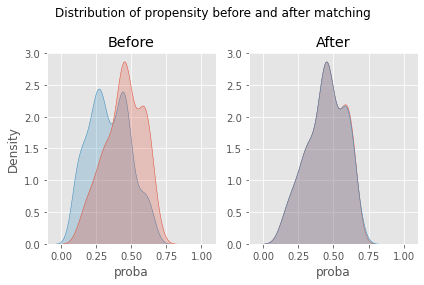

In [159]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Distribution of propensity before and after matching')

sns.kdeplot(df[~df[TREATMENT]].proba, color=T_COLOR, label=T_LABEL, ax=ax1, shade=True)
sns.kdeplot(df[df[TREATMENT]].proba,  color=C_COLOR, label=C_LABEL, ax=ax1, shade=True)
ax1.set_title('Before')

sns.kdeplot(GROUP_C.proba.to_numpy(), color=C_COLOR, label=C_LABEL, ax=ax2, shade=True)
sns.kdeplot(GROUP_T.proba.to_numpy(), color=T_COLOR, label=T_LABEL, ax=ax2, shade=True)
ax2.set_title('After')
ax2.set_xlabel('proba')
ax2.set_ylabel('')

for ax in fig.axes:
    ax.set_xlim(-.1, 1.1)

plt.tight_layout()
fig.savefig(f'../figs/distributions_propensity/{TREATMENT}_propensity.svg')

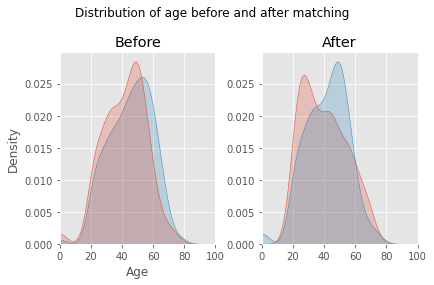

In [160]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Distribution of age before and after matching')

sns.kdeplot(df[~df[TREATMENT]].Age, color=T_COLOR, label=T_LABEL, ax=ax1, shade=True)
sns.kdeplot(df[df[TREATMENT]].Age,  color=C_COLOR, label=C_LABEL, ax=ax1, shade=True)
ax1.set_title('Before')

sns.kdeplot(GROUP_C.Age.to_numpy(), color=C_COLOR, label=C_LABEL, shade=True, ax=ax2)
sns.kdeplot(GROUP_T.Age.to_numpy(), color=T_COLOR, label=T_LABEL, shade=True, ax=ax2)
ax2.set_title('After')
ax2.set_ylabel('')
plt.tight_layout()

for ax in fig.axes:
    ax.set_xlim(0, 100)

fig.savefig(f'../figs/distributions_propensity/{TREATMENT}_age.svg')

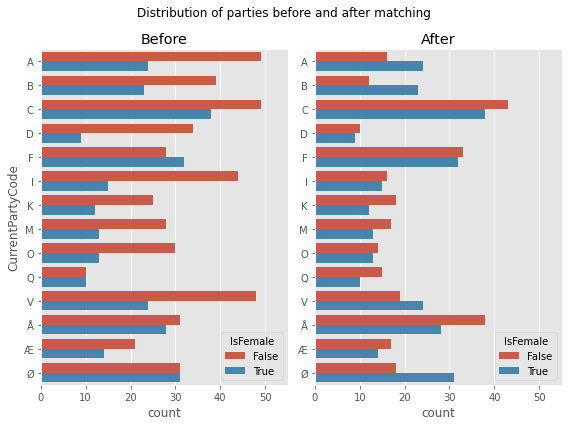

In [161]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
fig.suptitle('Distribution of parties before and after matching')

X = df.groupby(['CurrentPartyCode', TREATMENT]).agg(count=('CurrentPartyCode', 'count')).reset_index()
sns.barplot(data=X, y='CurrentPartyCode', x='count', hue=TREATMENT, ax=ax1)
ax1.set_title('Before')

X = GROUPS.groupby(['CurrentPartyCode', TREATMENT]).agg(count=('CurrentPartyCode', 'count')).reset_index()
sns.barplot(data=X, y='CurrentPartyCode', x='count', hue=TREATMENT, ax=ax2)
ax2.set_title('After')
ax2.set_ylabel('')

for ax in fig.axes:
    ax.set_xlim(0, 55)

plt.tight_layout()

fig.savefig(f'../figs/distributions_propensity/{TREATMENT}_parties.svg')

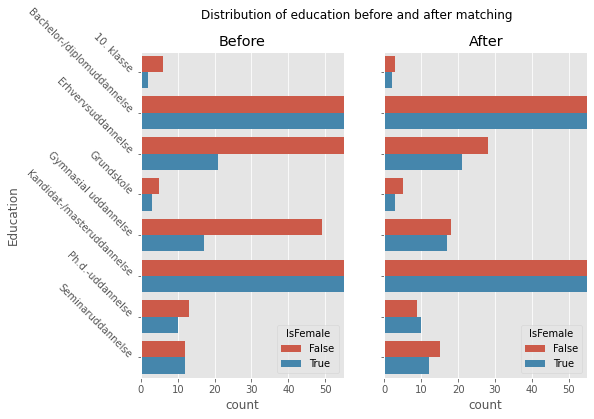

In [162]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
fig.suptitle('Distribution of education before and after matching')

X = df.groupby(['Education', TREATMENT]).agg(count=('Education', 'count')).reset_index()
sns.barplot(data=X, y='Education', x='count', hue=TREATMENT, ax=ax1)
ax1.set_title('Before')
fontdict = {'verticalalignment': 'baseline'}
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=-45, fontdict=fontdict)

X = GROUPS.groupby(['Education', TREATMENT]).agg(count=('Education', 'count')).reset_index()
sns.barplot(data=X, y='Education', x='count', hue=TREATMENT, ax=ax2)
ax2.set_title('After')
ax2.set_ylabel('')
ax2.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(0, 55)

# plt.tight_layout()
fig.savefig(f'../figs/distributions_propensity/{TREATMENT}_education.svg')

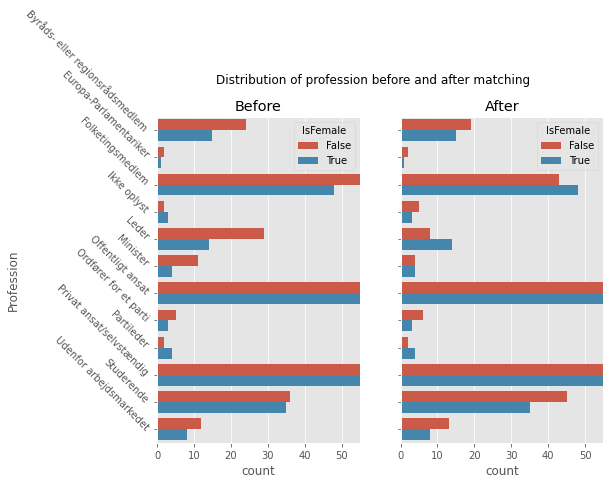

In [163]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
fig.suptitle('Distribution of profession before and after matching')

X = df.groupby(['Profession', TREATMENT]).agg(count=('Profession', 'count')).reset_index()
sns.barplot(data=X, y='Profession', x='count', hue=TREATMENT, ax=ax1)
ax1.set_title('Before')
fontdict = {'verticalalignment': 'baseline'}
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=-45, fontdict=fontdict)

X = GROUPS.groupby(['Profession', TREATMENT]).agg(count=('Profession', 'count')).reset_index()
sns.barplot(data=X, y='Profession', x='count', hue=TREATMENT, ax=ax2)
ax2.set_title('After')
ax2.set_ylabel('')
ax2.set_yticklabels([])

for ax in fig.axes:
    ax.set_xlim(0, 55)

# plt.tight_layout()
fig.savefig(f'../figs/distributions_propensity/{TREATMENT}_profession.svg')

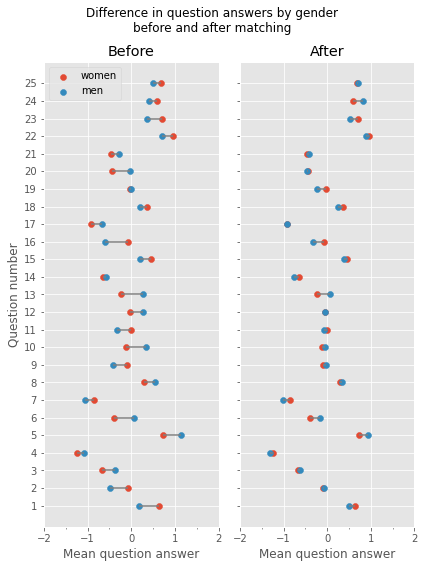

In [164]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,8))
fig.suptitle('Difference in question answers by gender\nbefore and after matching')

# unmatched
y = np.arange(1, 26)
x1 = np.array([df[df[TREATMENT]][str(i)].mean() for i in range(1, 26)])
x2 = np.array([df[~df[TREATMENT]][str(i)].mean() for i in range(1, 26)])

X = np.vstack((x1, x2)).T
# idx = np.argsort(-np.mean(X, axis=1))
# idx = np.argsort(np.abs(x1 - x2))
# x1 = x1[idx]
# x2 = x2[idx]

for n in y:
    a = min(x1[n-1], x2[n-1])
    b = max(x1[n-1], x2[n-1])
    ax1.hlines(n, a, b, color='grey')

ax1.scatter(x1, y, label='women')
ax1.scatter(x2, y, label='men')

ax1.set_yticks(y)

ax1.set_xlim(-2, 2)
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_minor_locator(MultipleLocator(.5))

ax1.set_title('Before')
ax1.set_xlabel('Mean question answer')
ax1.set_ylabel('Question number')

ax1.set_yticklabels(y)
ax1.legend()




# matched
x1 = np.array([GROUP_T[str(i)].mean() for i in range(1, 26)])
x2 = np.array([GROUP_C[str(i)].mean() for i in range(1, 26)])

X = np.vstack((x1, x2)).T
# idx = np.argsort(-np.mean(X, axis=1))
# idx = np.argsort(np.abs(x1 - x2))
# x1 = x1[idx]
# x2 = x2[idx]

for n in y:
    a = min(x1[n-1], x2[n-1])
    b = max(x1[n-1], x2[n-1])
    ax2.hlines(n, a, b, color='grey')

ax2.scatter(x1, y, label='men')
ax2.scatter(x2, y, label='women')

ax2.set_yticks(y)
ax2.set_yticklabels([])

ax2.set_xlim(-2, 2)
ax2.xaxis.set_major_locator(MultipleLocator(1))
ax2.xaxis.set_minor_locator(MultipleLocator(.5))

ax2.set_title('After')
ax2.set_xlabel('Mean question answer')

plt.tight_layout()

fig.savefig(f'../figs/distributions_propensity/{TREATMENT}_dumbell.svg')

In [165]:
t1 = GROUP_C[[str(i) for i in range(1, 31)]].to_numpy()
t2 = GROUP_T[[str(i) for i in range(1, 31)]].to_numpy()

p_threshold = 0.002

_, p_value = stats.ttest_rel(t1, t2)

In [166]:
for p in p_value[:25]:
    print(round(p, 4), '& ', end='')

0.2535 & 0.8922 & 0.7269 & 0.5721 & 0.0455 & 0.0529 & 0.1371 & 0.6792 & 0.589 & 0.562 & 0.6254 & 0.9504 & 0.0186 & 0.3153 & 0.6211 & 0.0562 & 1.0 & 0.3078 & 0.0753 & 0.8165 & 0.7612 & 0.3776 & 0.1795 & 0.0215 & 0.7867 & 

In [167]:
np.where(p_value <= p_threshold)

(array([25, 26], dtype=int64),)

<AxesSubplot: >

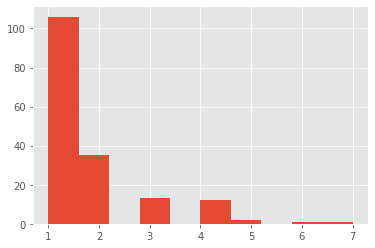

In [168]:
df[df[TREATMENT]].match.value_counts().hist()

<AxesSubplot: >

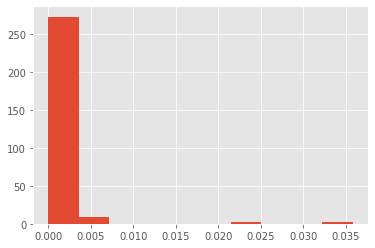

In [169]:
df[df[TREATMENT]].distance.hist()